In [10]:
import pandas as pd
import numpy as np
from itertools import combinations
from scipy.stats import f,pearsonr,spearmanr, laplace, norm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set(font_scale = 2)
sns.set_style("white")
rcParams['svg.fonttype'] = 'none'

In [11]:
pre_mpra_scores_file = "/projects/pfenninggroup/heather/ad_regression_revision/data/rare_var_effects/DNase_effect_scores.txt"
tl0_scores_file = "/projects/pfenninggroup/heather/ad_regression_revision/data/rare_var_effects/tl_original_effect_scores.txt"
tl1_scores_file = "/projects/pfenninggroup/heather/ad_regression_revision/data/rare_var_effects/tl1_effect_scores.txt"
tl2_scores_file = "/projects/pfenninggroup/heather/ad_regression_revision/data/rare_var_effects/tl2_effect_scores.txt"
tl3_scores_file = "/projects/pfenninggroup/heather/ad_regression_revision/data/rare_var_effects/tl3_effect_scores.txt"

In [12]:
def readScoresFileAndConcat(scores_files_list,
                            names_list):
    
    variant_info = pd.DataFrame()
    
    colsuffixes = ["effect_score",
                   "ref_score",
                   "alt_score"
                  ]
    
    tables_to_concat = []
    
    for i,scores_file in enumerate(scores_files_list):
        colnames = [names_list[i]+"_"+suffix for suffix in colsuffixes]
        scores = pd.read_csv(scores_file,
                             sep='\t',
                             names=colnames
                            )
        tables_to_concat.append(scores)
    
    variant_info = pd.concat(tables_to_concat,
                             axis=1
                            )
    return variant_info

In [13]:
scores_files_list = [pre_mpra_scores_file,
                     tl0_scores_file,
                     tl1_scores_file,
                     tl2_scores_file,
                     tl3_scores_file,
                    ]

names_list = ["DNase",
              "TL0",
              "TL1",
              "TL2",
              "TL3",
             ]

variant_info = readScoresFileAndConcat(scores_files_list,
                                       names_list
                                      )

In [14]:
variant_info['TLavg_effect_score'] = variant_info[['TL0_effect_score',
                                                   'TL1_effect_score',
                                                   'TL2_effect_score',
                                                   'TL3_effect_score']
                                                  ].mean(axis=1)

In [15]:
variant_info["DNase_effect_score_normed"] = variant_info["DNase_effect_score"]/np.std(variant_info["DNase_effect_score"])
variant_info["TL0_effect_score_normed"] = variant_info["TL0_effect_score"]/np.std(variant_info["TL0_effect_score"])
variant_info["TL1_effect_score_normed"] = variant_info["TL1_effect_score"]/np.std(variant_info["TL1_effect_score"])
variant_info["TL2_effect_score_normed"] = variant_info["TL2_effect_score"]/np.std(variant_info["TL2_effect_score"])
variant_info["TL3_effect_score_normed"] = variant_info["TL3_effect_score"]/np.std(variant_info["TL3_effect_score"])
variant_info["TLavg_effect_score_normed"] = variant_info["TLavg_effect_score"]/np.std(variant_info["TLavg_effect_score"])

In [16]:
dnase_effect_std = np.std(variant_info["DNase_effect_score"])
dnase_effect_scale = dnase_effect_std/np.sqrt(2)
num_samples = variant_info.loc[~variant_info['DNase_effect_score'].isna()].shape[0]
laplace_sample_for_dnase = laplace.rvs(loc=0, scale=dnase_effect_scale, size=num_samples)
norm_sample_for_dnase = norm.rvs(loc=0, scale=dnase_effect_std, size=num_samples)

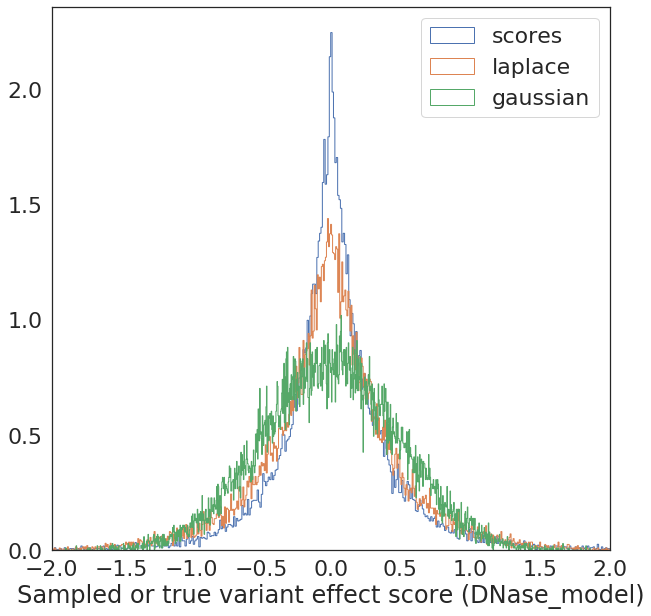

In [18]:
plt.figure(figsize=(10,10))
plt.hist(variant_info['DNase_effect_score'], histtype='step', bins=1000, density=True, label='scores')
plt.hist(laplace_sample_for_dnase, histtype='step', bins=1000, density=True, label='laplace')
plt.hist(norm_sample_for_dnase, histtype='step', bins=1000,  density=True, label='gaussian')
plt.xlabel('Sampled or true variant effect score (DNase_model)')
plt.xlim(-2,2)
plt.legend()
plt.savefig('plots/laplace_gaussian_empirical_dist.svg')
plt.savefig('plots/laplace_gaussian_empirical_dist.png')

In [19]:
print(np.std(variant_info["DNase_effect_score"]))
print(np.std(variant_info["TL0_effect_score"]))
print(np.std(variant_info["TL1_effect_score"]))
print(np.std(variant_info["TL2_effect_score"]))
print(np.std(variant_info["TL3_effect_score"]))
print(np.std(variant_info["TLavg_effect_score"]))

0.49065141222426556
0.06707125178722939
0.04168574300385446
0.051719412722815335
0.04679727323605236
0.04164062759822858


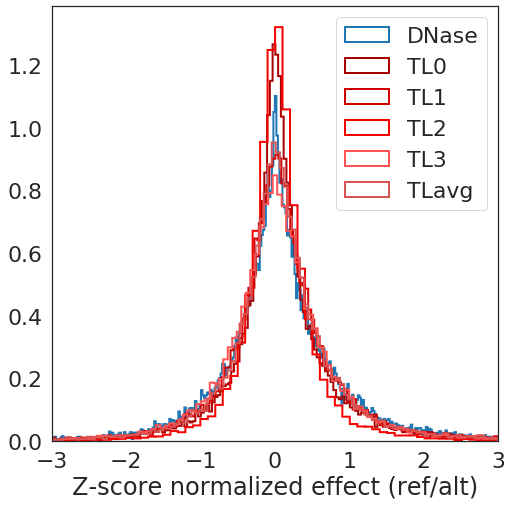

In [25]:
plt.figure(figsize=(8,8))
plt.hist(variant_info["DNase_effect_score_normed"],
         density=True,
         bins=1000,
         color='#1f77b4',
         histtype='step',
         label='DNase',
         linewidth=2
        )
plt.hist(variant_info["TL0_effect_score_normed"],
         density=True,
         bins=1000,
         color='#aa0000',
         histtype='step',
         label='TL0',
         linewidth=2
        )
plt.hist(variant_info["TL1_effect_score_normed"],
         density=True,
         bins=1000,
         color='#d00000',
         histtype='step',
         label='TL1',
         linewidth=2
        )

plt.hist(variant_info["TL2_effect_score_normed"],
         density=True,
         bins=1000,
         color='#f70000',
         histtype='step',
         label='TL2',
         linewidth=2
        )

plt.hist(variant_info["TL3_effect_score_normed"],
         density=True,
         bins=1000,
         color='#ff5353',
         histtype='step',
         label='TL3',
         linewidth=2
        )

plt.hist(variant_info["TLavg_effect_score_normed"],
         density=True,
         bins=1000,
         color='#d95353',
         histtype='step',
         label='TLavg',
         linewidth=2
        )


plt.xlim([-3,3])
plt.xlabel("Z-score normalized effect (ref/alt)")
plt.legend()
plt.savefig("plots/tl_models_score_distributions_corrected_script.svg")

In [65]:
def scatterPlotCellTypePairs(effect_scores_pair_dropna, ct1_name, ct2_name):    
    p = sns.jointplot(x=effect_scores_pair_dropna[ct1_name+"_"+"effect_score_normed"],
                      y=effect_scores_pair_dropna[ct2_name+"_"+"effect_score_normed"],
                      kind='hex',
                      color='red',
                      gridsize=2500,
                      rasterized=True
                     )
    p.ax_marg_x.remove()
    p.ax_marg_y.remove()
    
    r, rp = pearsonr(effect_scores_pair_dropna[ct1_name+"_"+"effect_score_normed"],
                     effect_scores_pair_dropna[ct2_name+"_"+"effect_score_normed"])
    rho, rhop = spearmanr(effect_scores_pair_dropna[ct1_name+"_"+"effect_score_normed"],
                          effect_scores_pair_dropna[ct2_name+"_"+"effect_score_normed"])
    p.set_axis_labels(ct1_name, ct2_name)

    p.ax_joint.annotate("r={:0.2}, p={:0.2}".format(r,rp)+ "\n" + r"$\rho$={:0.2}, p={:0.2}".format(rho, rhop),
                        xy=(0.5,0.1),
                        xycoords="axes fraction",
                        ha="left",
                        va="center",
                        bbox={'fc': 'none', 'ec': 'none'},
                        color='red',
                        fontsize=15,
                        weight='bold'
                       )
    plt.xlim([-3,3])
    plt.ylim([-3,3])
    plt.savefig("../plots/"+"_".join([ct1_name,ct2_name,"variant","scores","comparison"])+".svg")

In [66]:
snigdha_snp_list_unique_file = "/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ad_variants_processing/common_variants/snigdha_snp_list_unique_haploreg_hg19_positions.txt"
snigdha_snp_list_variant_info = pd.read_csv(snigdha_snp_list_unique_file, sep='\t')

In [67]:
tl0_snigdha_snp_list_unique_scores_file =  "/projects/pfenninggroup/heather/ad_regression_revision/data/snp_effects/orig_transfer_model/predictions_orig_transfer_model_altminusref.npy"
tl1_snigdha_snp_list_unique_scores_file =  "/projects/pfenninggroup/heather/ad_regression_revision/data/snp_effects/mpra_finetune_quarter1/predictions_mpra_finetune_quarter1_altminusref.npy"
tl2_snigdha_snp_list_unique_scores_file =  "/projects/pfenninggroup/heather/ad_regression_revision/data/snp_effects/mpra_finetune_quarter2/predictions_mpra_finetune_quarter2_altminusref.npy"
tl3_snigdha_snp_list_unique_scores_file =  "/projects/pfenninggroup/heather/ad_regression_revision/data/snp_effects/mpra_finetune_quarter3/predictions_mpra_finetune_quarter3_altminusref.npy"
dnase_snigdha_snp_list_unique_scores_file =  "/projects/pfenninggroup/heather/ad_regression_revision/data/snp_effects/DNase_model/predictions_DNase_model_altminusref.npy"

In [68]:
#negating here because these were computed as alt over ref and not ref over alt
snigdha_snp_list_variant_info['TL0'] = -np.load(tl0_snigdha_snp_list_unique_scores_file)
snigdha_snp_list_variant_info['TL1'] = -np.load(tl1_snigdha_snp_list_unique_scores_file)
snigdha_snp_list_variant_info['TL2'] = -np.load(tl2_snigdha_snp_list_unique_scores_file)
snigdha_snp_list_variant_info['TL3'] = -np.load(tl3_snigdha_snp_list_unique_scores_file)
snigdha_snp_list_variant_info['TLavg'] = snigdha_snp_list_variant_info[['TL0',
                                                                        'TL1',
                                                                        'TL2',
                                                                        'TL3'
                                                                       ]].mean(axis=1)

snigdha_snp_list_variant_info['DNase'] = -np.load(dnase_snigdha_snp_list_unique_scores_file)

In [69]:
snigdha_snp_list_variant_info['TL0_normed'] = snigdha_snp_list_variant_info['TL0']/np.std(variant_info["TL0_effect_score"])
snigdha_snp_list_variant_info['TL1_normed'] = snigdha_snp_list_variant_info['TL1']/np.std(variant_info["TL1_effect_score"])
snigdha_snp_list_variant_info['TL2_normed'] = snigdha_snp_list_variant_info['TL2']/np.std(variant_info["TL2_effect_score"])
snigdha_snp_list_variant_info['TL3_normed'] = snigdha_snp_list_variant_info['TL3']/np.std(variant_info["TL3_effect_score"])
snigdha_snp_list_variant_info['TLavg_normed'] = snigdha_snp_list_variant_info['TLavg']/np.std(variant_info["TLavg_effect_score"])
snigdha_snp_list_variant_info['DNase_normed'] = snigdha_snp_list_variant_info['DNase']/np.std(variant_info["DNase_effect_score"])

In [70]:
tanzi_variants_gm_overlap_file = "/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ad_variants_processing/rare_variants/merged.SNVs.NIMH+ADSP_v2_gm_intersect.bed"

In [71]:
tanzi_variants_gm_overlap_info = pd.read_csv(tanzi_variants_gm_overlap_file, sep='\t', names=['CHR', 'START', 'END', 'RSID', 'GM_DNASE_OVERLAP'])

In [72]:
tanzi_variants_gm_overlap_info.head()

,CHR,START,END,RSID,GM_DNASE_OVERLAP
0,chr1,10176,10177,rs201752861,0
1,chr1,10249,10250,rs199706086,0
2,chr1,10256,10257,rs111200574,0
3,chr1,10290,10291,rs145427775,0
4,chr1,10326,10327,rs112750067,0


In [73]:
snigdha_snp_list_variant_info_w_gm_overlap_info = snigdha_snp_list_variant_info.merge(tanzi_variants_gm_overlap_info,
                                                                                     left_on='LD_RSID',
                                                                                     right_on='RSID'
                                                                                    )

In [74]:
snigdha_snp_list_variant_info_overlapping_gm_peaks = snigdha_snp_list_variant_info_w_gm_overlap_info.loc[snigdha_snp_list_variant_info_w_gm_overlap_info['GM_DNASE_OVERLAP']>0]

In [75]:
dnase_model_sig_variant_info = snigdha_snp_list_variant_info_overlapping_gm_peaks.loc[snigdha_snp_list_variant_info_overlapping_gm_peaks['DNase_normed'].abs()>2]

In [76]:
tl_model_sig_variant_info = snigdha_snp_list_variant_info_overlapping_gm_peaks.loc[snigdha_snp_list_variant_info_overlapping_gm_peaks['TLavg_normed'].abs()>2]

In [77]:
tl0_sig_variant_info = snigdha_snp_list_variant_info_overlapping_gm_peaks.loc[snigdha_snp_list_variant_info_overlapping_gm_peaks['TL0_normed'].abs()>2]
tl1_sig_variant_info = snigdha_snp_list_variant_info_overlapping_gm_peaks.loc[snigdha_snp_list_variant_info_overlapping_gm_peaks['TL1_normed'].abs()>2]
tl2_sig_variant_info = snigdha_snp_list_variant_info_overlapping_gm_peaks.loc[snigdha_snp_list_variant_info_overlapping_gm_peaks['TL2_normed'].abs()>2]
tl3_sig_variant_info = snigdha_snp_list_variant_info_overlapping_gm_peaks.loc[snigdha_snp_list_variant_info_overlapping_gm_peaks['TL3_normed'].abs()>2]

In [78]:
dnase_model_sig_variant_info

,CHR_x,haploreg_hg19_pos,LD_RSID,REF,ALT,TL0,TL1,TL2,TL3,TLavg,...,TL1_normed,TL2_normed,TL3_normed,TLavg_normed,DNase_normed,CHR_y,START,END,RSID,GM_DNASE_OVERLAP
167,chr11,60019150,rs636317,C,T,0.129878,0.012007,0.030516,0.020429,0.048208,...,0.288030,0.590033,0.436541,1.157705,7.070793,chr11,60251676,60251677,rs636317,1
190,chr1,161155392,rs4575098,G,A,0.011383,0.030793,-0.007791,-0.011801,0.005646,...,0.738695,-0.150634,-0.252170,0.135592,2.636456,chr1,161185601,161185602,rs4575098,2
362,chr15,59042363,rs514049,C,A,0.035390,0.038215,0.012295,0.036129,0.030507,...,0.916744,0.237718,0.772026,0.732629,2.267344,chr15,58750163,58750164,rs514049,1
486,chr17,5158714,rs61481506,T,C,-0.025857,-0.011564,-0.017520,-0.031941,-0.021721,...,-0.277421,-0.338748,-0.682547,-0.521620,-2.327269,chr17,5255418,5255419,rs61481506,2
948,chr6,32577733,rs9271163,C,T,-0.048809,-0.004979,-0.004284,-0.013991,-0.018016,...,-0.119452,-0.082827,-0.298978,-0.432655,-2.104458,chr6,32609955,32609956,rs9271163,2
951,chr6,32577889,rs9271170,T,C,-0.124374,-0.100191,-0.063988,-0.108388,-0.099235,...,-2.403489,-1.237211,-2.316124,-2.383139,-2.439197,chr6,32610111,32610112,rs9271170,2
960,chr6,32578230,rs9271182,A,G,-0.396924,-0.175960,-0.086996,-0.166733,-0.206653,...,-4.221110,-1.682071,-3.562886,-4.962780,-5.502971,chr6,32610452,32610453,rs9271182,2


In [79]:
tl_model_sig_variant_info

,CHR_x,haploreg_hg19_pos,LD_RSID,REF,ALT,TL0,TL1,TL2,TL3,TLavg,...,TL1_normed,TL2_normed,TL3_normed,TLavg_normed,DNase_normed,CHR_y,START,END,RSID,GM_DNASE_OVERLAP
951,chr6,32577889,rs9271170,T,C,-0.124374,-0.100191,-0.063988,-0.108388,-0.099235,...,-2.403489,-1.237211,-2.316124,-2.383139,-2.439197,chr6,32610111,32610112,rs9271170,2
960,chr6,32578230,rs9271182,A,G,-0.396924,-0.175960,-0.086996,-0.166733,-0.206653,...,-4.221110,-1.682071,-3.562886,-4.962780,-5.502971,chr6,32610452,32610453,rs9271182,2


In [80]:
tl0_sig_variant_info

,CHR_x,haploreg_hg19_pos,LD_RSID,REF,ALT,TL0,TL1,TL2,TL3,TLavg,...,TL1_normed,TL2_normed,TL3_normed,TLavg_normed,DNase_normed,CHR_y,START,END,RSID,GM_DNASE_OVERLAP
960,chr6,32578230,rs9271182,A,G,-0.396924,-0.17596,-0.086996,-0.166733,-0.206653,...,-4.22111,-1.682071,-3.562886,-4.96278,-5.502971,chr6,32610452,32610453,rs9271182,2


In [81]:
tl1_sig_variant_info

,CHR_x,haploreg_hg19_pos,LD_RSID,REF,ALT,TL0,TL1,TL2,TL3,TLavg,...,TL1_normed,TL2_normed,TL3_normed,TLavg_normed,DNase_normed,CHR_y,START,END,RSID,GM_DNASE_OVERLAP
951,chr6,32577889,rs9271170,T,C,-0.124374,-0.100191,-0.063988,-0.108388,-0.099235,...,-2.403489,-1.237211,-2.316124,-2.383139,-2.439197,chr6,32610111,32610112,rs9271170,2
960,chr6,32578230,rs9271182,A,G,-0.396924,-0.175960,-0.086996,-0.166733,-0.206653,...,-4.221110,-1.682071,-3.562886,-4.962780,-5.502971,chr6,32610452,32610453,rs9271182,2


In [82]:
tl2_sig_variant_info

,CHR_x,haploreg_hg19_pos,LD_RSID,REF,ALT,TL0,TL1,TL2,TL3,TLavg,...,TL1_normed,TL2_normed,TL3_normed,TLavg_normed,DNase_normed,CHR_y,START,END,RSID,GM_DNASE_OVERLAP


In [83]:
tl3_sig_variant_info

,CHR_x,haploreg_hg19_pos,LD_RSID,REF,ALT,TL0,TL1,TL2,TL3,TLavg,...,TL1_normed,TL2_normed,TL3_normed,TLavg_normed,DNase_normed,CHR_y,START,END,RSID,GM_DNASE_OVERLAP
416,chr17,47338083,rs1010322,C,G,-0.021719,0.039340,0.009121,0.098011,0.031188,...,0.943717,0.176352,2.094369,0.748981,0.983289,chr17,49260720,49260721,rs1010322,5
951,chr6,32577889,rs9271170,T,C,-0.124374,-0.100191,-0.063988,-0.108388,-0.099235,...,-2.403489,-1.237211,-2.316124,-2.383139,-2.439197,chr6,32610111,32610112,rs9271170,2
960,chr6,32578230,rs9271182,A,G,-0.396924,-0.175960,-0.086996,-0.166733,-0.206653,...,-4.221110,-1.682071,-3.562886,-4.962780,-5.502971,chr6,32610452,32610453,rs9271182,2


In [84]:
variant_info.loc[(variant_info['TLavg_effect_score_normed'].abs()>2)
                 & (variant_info['DNase_effect_score_normed'].abs()>2)].shape

(307, 22)

In [85]:
variant_info.loc[(variant_info['TLavg_effect_score_normed'].abs()>2)
                 & (variant_info['DNase_effect_score_normed'].abs()<1)].shape

(611, 22)

In [86]:
variant_info.loc[(variant_info['TLavg_effect_score_normed'].abs()<1)
                 & (variant_info['DNase_effect_score_normed'].abs()<2)].shape

(22146, 22)

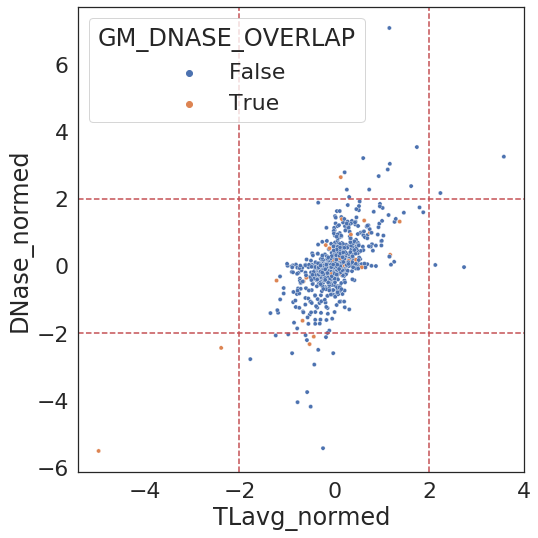

In [87]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=snigdha_snp_list_variant_info_w_gm_overlap_info,
                x='TLavg_normed',
                y='DNase_normed',
                hue=(snigdha_snp_list_variant_info_w_gm_overlap_info['GM_DNASE_OVERLAP']>1),
                s=18
               )
plt.axhline(y=2,color='r',linestyle='--')
plt.axhline(y=-2,color='r',linestyle='--')
plt.axvline(x=2,color='r',linestyle='--')
plt.axvline(x=-2,color='r',linestyle='--')
plt.tight_layout()

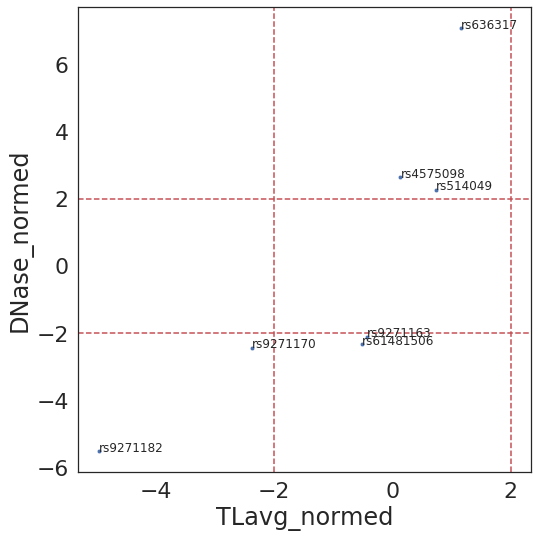

In [88]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=dnase_model_sig_variant_info,
                x='TLavg_normed',
                y='DNase_normed',
                s=18
               )

for i,row in dnase_model_sig_variant_info.iterrows():
    plt.text(x=row["TLavg_normed"],
             y=row["DNase_normed"],
             s=row["LD_RSID"],
             fontsize=12
            )
        
plt.axhline(y=2,color='r',linestyle='--')
plt.axhline(y=-2,color='r',linestyle='--')
plt.axvline(x=2,color='r',linestyle='--')
plt.axvline(x=-2,color='r',linestyle='--')
plt.tight_layout()

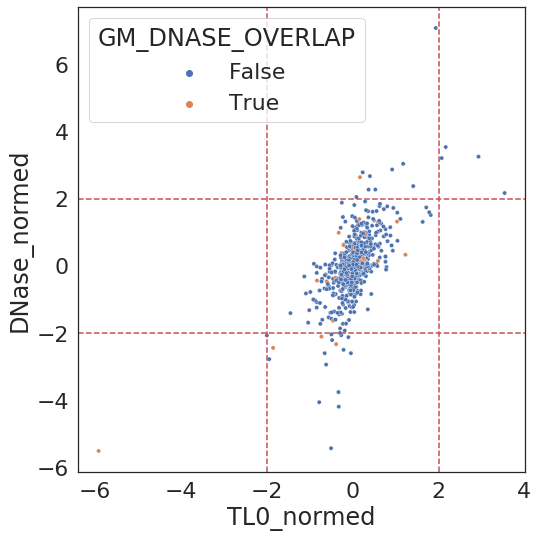

In [89]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=snigdha_snp_list_variant_info_w_gm_overlap_info,
                x='TL0_normed',
                y='DNase_normed',
                hue=(snigdha_snp_list_variant_info_w_gm_overlap_info['GM_DNASE_OVERLAP']>1),
                s=18
               )
plt.axhline(y=2,color='r',linestyle='--')
plt.axhline(y=-2,color='r',linestyle='--')
plt.axvline(x=2,color='r',linestyle='--')
plt.axvline(x=-2,color='r',linestyle='--')
plt.tight_layout()

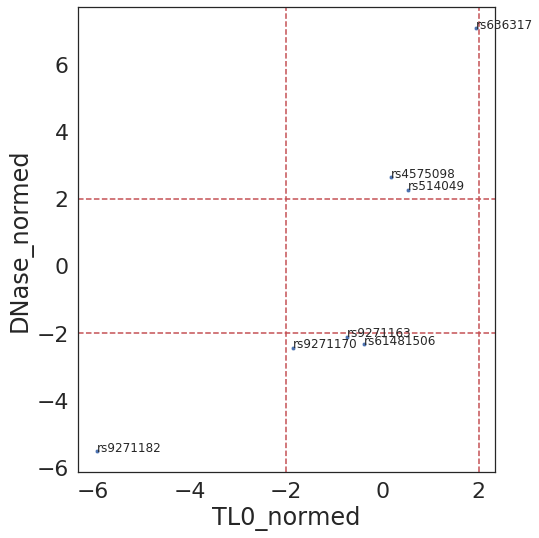

In [90]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=dnase_model_sig_variant_info,
                x='TL0_normed',
                y='DNase_normed',
                s=18
               )

for i,row in dnase_model_sig_variant_info.iterrows():
    plt.text(x=row["TL0_normed"],
             y=row["DNase_normed"],
             s=row["LD_RSID"],
             fontsize=12
            )
        
plt.axhline(y=2,color='r',linestyle='--')
plt.axhline(y=-2,color='r',linestyle='--')
plt.axvline(x=2,color='r',linestyle='--')
plt.axvline(x=-2,color='r',linestyle='--')
plt.tight_layout()

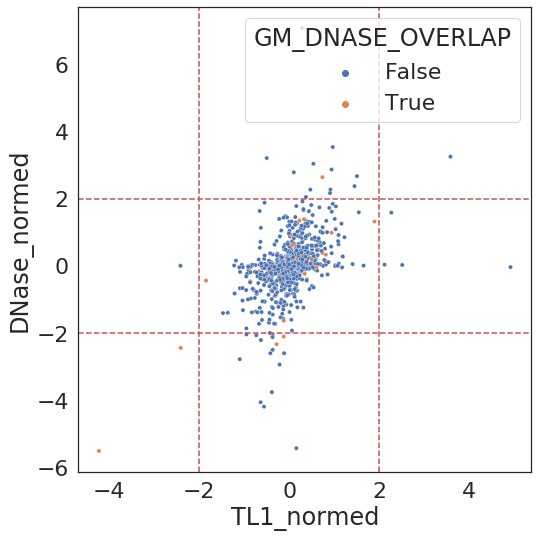

In [91]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=snigdha_snp_list_variant_info_w_gm_overlap_info,
                x='TL1_normed',
                y='DNase_normed',
                hue=(snigdha_snp_list_variant_info_w_gm_overlap_info['GM_DNASE_OVERLAP']>1),
                s=18
               )
plt.axhline(y=2,color='r',linestyle='--')
plt.axhline(y=-2,color='r',linestyle='--')
plt.axvline(x=2,color='r',linestyle='--')
plt.axvline(x=-2,color='r',linestyle='--')
plt.tight_layout()

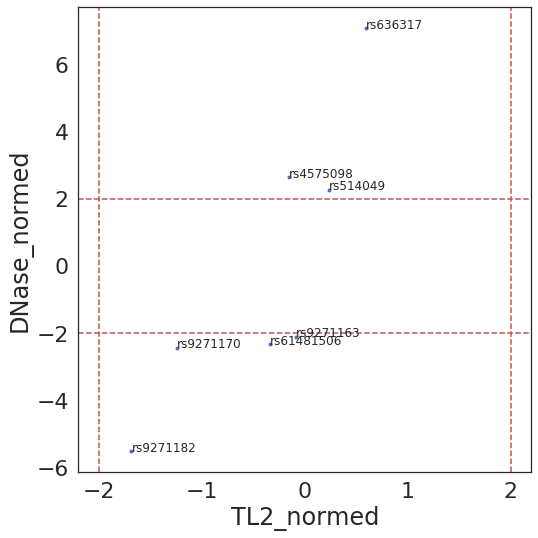

In [92]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=dnase_model_sig_variant_info,
                x='TL2_normed',
                y='DNase_normed',
                s=18
               )

for i,row in dnase_model_sig_variant_info.iterrows():
    plt.text(x=row["TL2_normed"],
             y=row["DNase_normed"],
             s=row["LD_RSID"],
             fontsize=12
            )
        
plt.axhline(y=2,color='r',linestyle='--')
plt.axhline(y=-2,color='r',linestyle='--')
plt.axvline(x=2,color='r',linestyle='--')
plt.axvline(x=-2,color='r',linestyle='--')
plt.tight_layout()

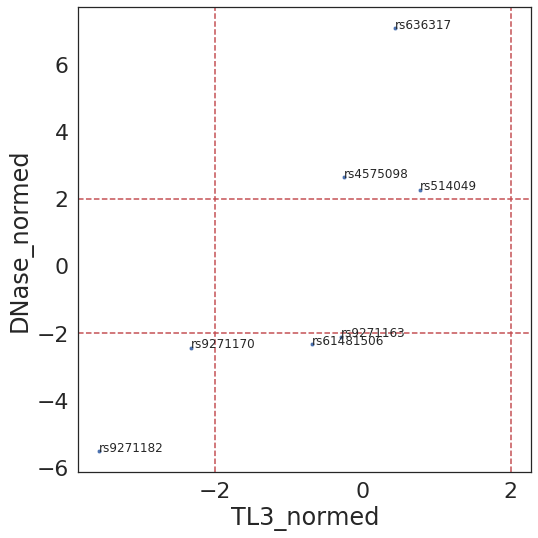

In [93]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=dnase_model_sig_variant_info,
                x='TL3_normed',
                y='DNase_normed',
                s=18
               )

for i,row in dnase_model_sig_variant_info.iterrows():
    plt.text(x=row["TL3_normed"],
             y=row["DNase_normed"],
             s=row["LD_RSID"],
             fontsize=12
            )
        
plt.axhline(y=2,color='r',linestyle='--')
plt.axhline(y=-2,color='r',linestyle='--')
plt.axvline(x=2,color='r',linestyle='--')
plt.axvline(x=-2,color='r',linestyle='--')
plt.tight_layout()

In [94]:
tanzi_2m_downsample_variant_info = pd.read_csv("/projects/pfenninggroup/heather/ad_regression_revision/data/snp_downsample/overlap_info.bed",
                                               sep='\t',
                                               names=['CHR', 'START', 'END', 'RSID', 'GM_DNASE_OVERLAP']
                                              )

In [95]:
tanzi_2m_downsample_variant_info.shape

(2000000, 5)

In [96]:
variant_info.shape

(2000000, 22)

In [97]:
tanzi_2m_downsample_variant_info = pd.concat([tanzi_2m_downsample_variant_info,variant_info],axis=1)

In [98]:
tanzi_2m_downsample_variant_info_gm_overlapping = tanzi_2m_downsample_variant_info.loc[tanzi_2m_downsample_variant_info['GM_DNASE_OVERLAP']>0]

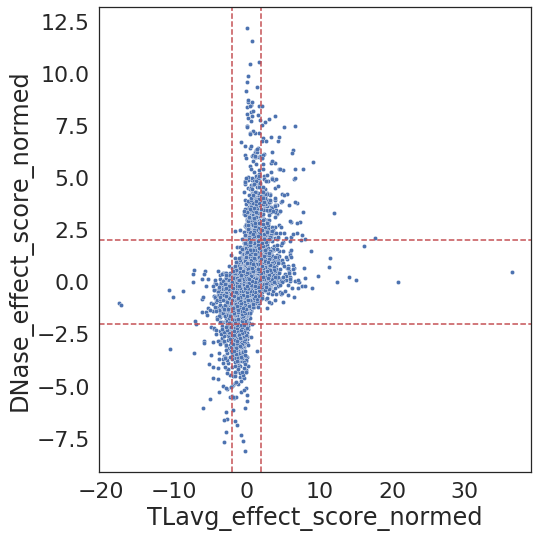

In [99]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=tanzi_2m_downsample_variant_info_gm_overlapping,
                x='TLavg_effect_score_normed',
                y='DNase_effect_score_normed',
                s=18
               )
plt.axhline(y=2,color='r',linestyle='--')
plt.axhline(y=-2,color='r',linestyle='--')
plt.axvline(x=2,color='r',linestyle='--')
plt.axvline(x=-2,color='r',linestyle='--')
plt.tight_layout()

In [100]:
print((tanzi_2m_downsample_variant_info_gm_overlapping['TLavg_effect_score_normed'].abs()>2).sum())
print((tanzi_2m_downsample_variant_info_gm_overlapping['DNase_effect_score_normed'].abs()>2).sum())

1163
1348


In [101]:
print(((tanzi_2m_downsample_variant_info_gm_overlapping['TLavg_effect_score_normed'].abs()>2)
       & (tanzi_2m_downsample_variant_info_gm_overlapping['DNase_effect_score_normed'].abs()>2)).sum())

307


In [102]:
print(((tanzi_2m_downsample_variant_info_gm_overlapping['TLavg_effect_score_normed'].abs()>2)
       & (tanzi_2m_downsample_variant_info_gm_overlapping['DNase_effect_score_normed'].abs()<2)).sum())

856


In [103]:
print(((tanzi_2m_downsample_variant_info_gm_overlapping['TLavg_effect_score_normed'].abs()<2)
       & (tanzi_2m_downsample_variant_info_gm_overlapping['DNase_effect_score_normed'].abs()>2)).sum())

1041


Text(0.5, 1, 'TL model score Pearson correlations (larger downsampled set)')

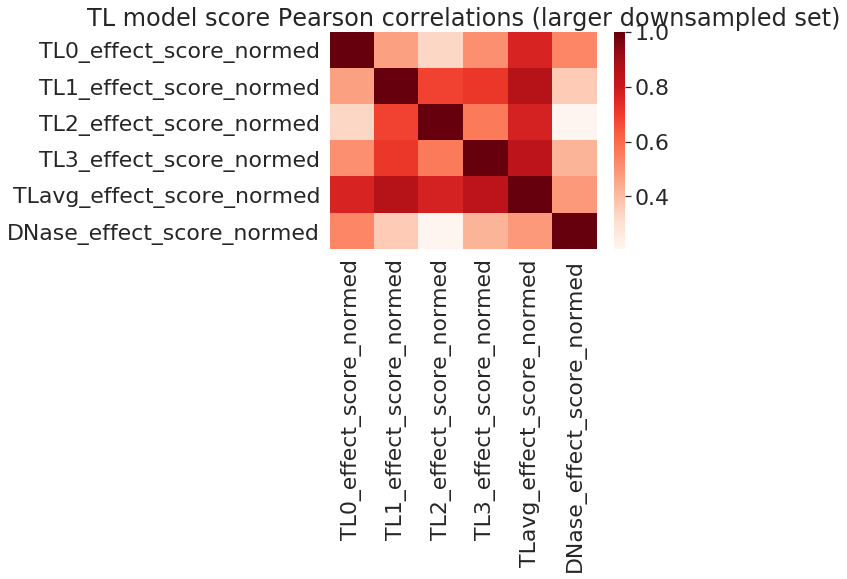

In [104]:
sns.heatmap(tanzi_2m_downsample_variant_info_gm_overlapping[['TL0_effect_score_normed',
              'TL1_effect_score_normed',
              'TL2_effect_score_normed',
              'TL3_effect_score_normed',
              'TLavg_effect_score_normed',
              'DNase_effect_score_normed'
             ]].corr(method='pearson'),
           cmap='Reds'
          )
plt.title('TL model score Pearson correlations (larger downsampled set)')

Text(0.5, 1, 'TL model score Spearman correlations (larger downsampled set)')

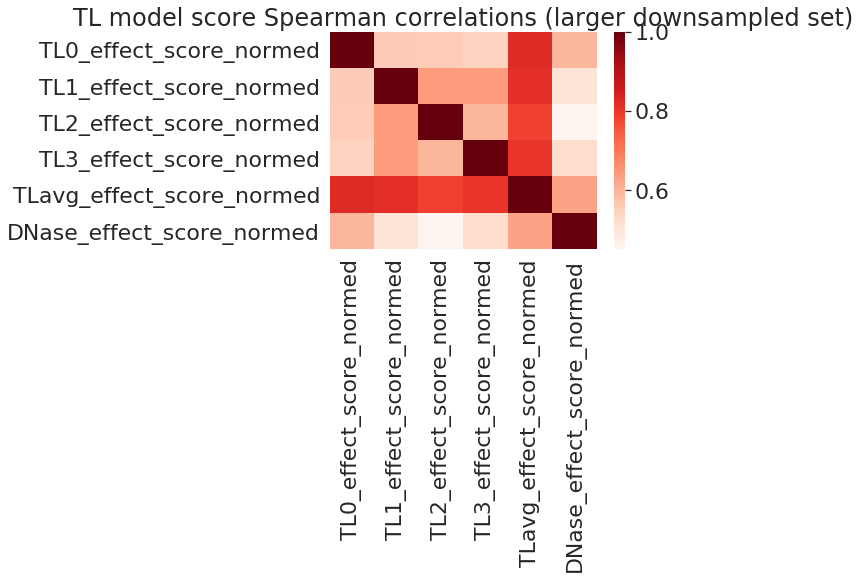

In [105]:
sns.heatmap(tanzi_2m_downsample_variant_info_gm_overlapping[['TL0_effect_score_normed',
              'TL1_effect_score_normed',
              'TL2_effect_score_normed',
              'TL3_effect_score_normed',
              'TLavg_effect_score_normed',
              'DNase_effect_score_normed'
             ]].corr(method='spearman'),
             cmap='Reds'
          )
plt.title('TL model score Spearman correlations (larger downsampled set)')

In [106]:
print("Sig in TLavg")
print((tanzi_2m_downsample_variant_info_gm_overlapping['TLavg_effect_score_normed'].abs()>2).sum())
print("Sig in DNase")
print((tanzi_2m_downsample_variant_info_gm_overlapping['DNase_effect_score_normed'].abs()>2).sum())
print("Sig in both:")
print(((tanzi_2m_downsample_variant_info_gm_overlapping['TLavg_effect_score_normed'].abs()>2)
       & (tanzi_2m_downsample_variant_info_gm_overlapping['DNase_effect_score_normed'].abs()>2)).sum())
print("Sig only in TLavg")
print(((tanzi_2m_downsample_variant_info_gm_overlapping['TLavg_effect_score_normed'].abs()>2)
       & (tanzi_2m_downsample_variant_info_gm_overlapping['DNase_effect_score_normed'].abs()<2)).sum())
print("Sig only in DNase")
print(((tanzi_2m_downsample_variant_info_gm_overlapping['TLavg_effect_score_normed'].abs()<2)
       & (tanzi_2m_downsample_variant_info_gm_overlapping['DNase_effect_score_normed'].abs()>2)).sum())

Sig in TLavg
1163
Sig in DNase
1348
Sig in both:
307
Sig only in TLavg
856
Sig only in DNase
1041


In [107]:
tanzi_2m_downsample_variant_info_gm_overlapping_further_downsample = tanzi_2m_downsample_variant_info_gm_overlapping.sample(n=20000)

In [108]:
tanzi_2m_downsample_variant_info_gm_overlapping.to_csv("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/geuvadis_lcl_eqtl/tanzi_2m_downsample_tl_model_scores_and_gm_overlaps.txt",
                                                       sep='\t',
                                                       index=False,
                                                       header=True
                                                      )